# Import Libraries

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/cycleGAN")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
checkpoints	landscape.jpg  model.png      train_images
CycleGAN.ipynb	logs	       painting.jpeg


## Import Tensorflow and other libraries

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import os
import time
import matplotlib.pyplot as plt

from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## GPU Info

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
  device_name = tf.test.gpu_device_name()
  print('Found GPU at: {}'.format(device_name))

Sun Jul 12 04:37:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Hyperparameters

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 1 
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 10
LEARNING_RATE = 2e-4
BETA_1 = 0.5
EPOCHS = 200
DECAY_EPOCHS = 100

# Input Pipeline

## Load a dataset

The easiest way of loading a dataset is tfds.load. It will:

1. Download the data and save it as tfrecord files.
2. Load the tfrecord and create the tf.data.Dataset

train_X: Paintings

train_Y: Landscape

In [5]:
# Monet
# dataset, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

# cezanne
dataset, metadata = tfds.load('cycle_gan/cezanne2photo', with_info=True, as_supervised=True) 

# ukiyoe
# dataset, metadata = tfds.load('cycle_gan/ukiyoe2photo', with_info=True, as_supervised=True) 

# vangogh
# dataset, metadata = tfds.load('cycle_gan/vangogh2photo', with_info=True, as_supervised=True) 

train_X, train_Y = dataset['trainA'], dataset['trainB']
test_X, test_Y = dataset['testA'], dataset['testB']

print(metadata)

tfds.core.DatasetInfo(
    name='cycle_gan',
    version=2.0.0,
    description='A dataset consisting of images from two classes A and B (For example: horses/zebras, apple/orange,...)',
    homepage='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7621,
    splits={
        'testA': 58,
        'testB': 751,
        'trainA': 525,
        'trainB': 6287,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/ZhuPIE17,
      author    = {Jun{-}Yan Zhu and
                   Taesung Park and
                   Phillip Isola and
                   Alexei A. Efros},
      title     = {Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial
                   Networks},
      journal   = {CoRR},
      volume    = {abs/1703.10593},
 

## Create Dataset

In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  
  return cropped_image

# Normalize the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1

  return image

In [7]:
def random_jitter(image):
  # Resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring 
  image = tf.image.random_flip_left_right(image)

  return image

In [8]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [9]:
# Create training dataset
train_X = train_X.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache()
train_Y = train_Y.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache()

train_dataset = tf.data.Dataset.zip((train_X, train_Y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(2)

In [10]:
# Create testing dataset
test_X = test_X.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache()
test_Y = test_Y.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache()

test_dataset = tf.data.Dataset.zip((test_X, test_Y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
total_batches = len(list(train_dataset.as_numpy_iterator()))
print('Batch size: {}, Total batches per epoch: {}'.format(BATCH_SIZE, total_batches))

Batch size: 1, Total batches per epoch: 525


In [12]:
imgX = plt.imread("painting.jpeg")
imgX = preprocess_image_train(imgX, 0)
imgX = imgX[tf.newaxis, :]

imgY = plt.imread("landscape.jpg")
imgY = preprocess_image_train(imgY, 0)
imgY = imgY[tf.newaxis, :]

## Visualize Random Jittering

1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip image horizonatally 

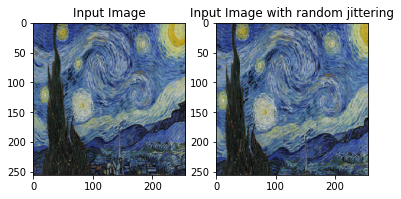

In [13]:
plt.subplot(121)
plt.title('Input Image')
plt.imshow(imgX[0]*0.5 + 0.5)

plt.subplot(122)
plt.title('Input Image with random jittering')
plt.imshow(random_jitter(imgX[0]) * 0.5 + 0.5)

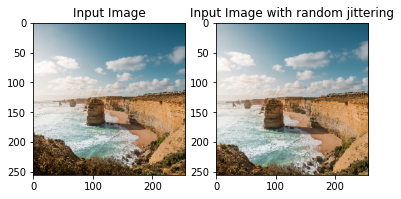

In [14]:
plt.subplot(121)
plt.title('Input Image')
plt.imshow(imgY[0]*0.5 + 0.5)

plt.subplot(122)
plt.title('Input Image with random jittering')
plt.imshow(random_jitter(imgY[0]) * 0.5 + 0.5)

# Build the Generator

## ResNet

In [15]:
class Padding2D(tf.keras.layers.Layer):
  def __init__(self, padding, padding_type, **kwargs):
    super(Padding2D, self).__init__(**kwargs)
    self.padding = [[0, 0], [padding, padding], [padding, padding], [0, 0]]
    self.padding_type = padding_type

  def call(self, inputs, **kwargs):
    if self.padding_type == "reflect":
      return tf.pad(inputs, self.padding, mode='REFLECT')

    elif self.padding_type == "zero":
      return tf.pad(inputs, self.padding, mode='CONSTANT')

    elif self.padding_type == "symmetric":
      return tf.pad(inputs, self.padding, mode='SYMMETRIC')
    else:
      raise NotImplementedError('padding [%s] is not implemented' % self.padding_type)

In [16]:
def conv(filters, kernel_size, strides=1, padding="same", name="", norm_type="InstanceNorm", use_bias=True):
	# Weights initializer
	init = tf.random_normal_initializer(0., 0.02)

	g = tf.keras.Sequential(name=name)
 
	g.add(tf.keras.layers.Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=init, use_bias=use_bias))
	
	if norm_type.lower()=="batchnorm":
		g.add(tf.keras.layers.BatchNormalization())
	elif norm_type.lower()=="instancenorm":
		g.add(tfa.layers.InstanceNormalization(axis=-1)) 
	
	g.add(tf.keras.layers.Activation('relu'))
 
	return g

def convTranspose(filters, kernel_size, strides=1, padding="same", name="", norm_type="instanceNorm", use_bias=True):
	# Weights initializer
	init = tf.random_normal_initializer(0, 0.02)

	g = tf.keras.Sequential(name=name)
	g.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides, padding=padding, kernel_initializer=init, use_bias=use_bias))

	if norm_type.lower()=="batchnorm":
		g.add(tf.keras.layers.BatchNormalization())
	elif norm_type.lower()=="instancenorm":
		g.add(tfa.layers.InstanceNormalization(axis=-1)) 
	
	g.add(tf.keras.layers.Activation('relu'))
 
	return g

In [17]:
# generator a resnet block
def resnet_block(n_filters, input_layer, use_dropout, name="", padding_type="reflect", norm_type="InstanceNorm", type_net="resnet", use_bias=True):
	"""
	Initialize the Resnet block

	A resnet block is a conv black with skip connections.
	Original renet paper: https://arxiv.org/pdf/1512.03385.pdf
	"""
	# Weight initialization
	initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
	
	g = tf.keras.Sequential(name=name)
 
	g.add(Padding2D(1, padding_type=padding_type))
	g.add(tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding="valid", kernel_initializer=initializer, use_bias=use_bias))
 
	if norm_type.lower()=="batchborm":
		g.add(tf.keras.layers.BatchNormalization())
	elif norm_type.lower()=="instancenorm":
		g.add(tfa.layers.InstanceNormalization(axis=-1))
	else:
		raise NotImplementedError('Norm Type [%s] is invalid' % norm_type)

	g.add(tf.keras.layers.Activation('relu'))
 
	if use_dropout:
		g.add(tf.keras.layers.Dropout(0.5))
 
	g.add(Padding2D(1, padding_type=padding_type))
	g.add(tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding="valid", kernel_initializer=initializer, use_bias=use_bias))

	if norm_type.lower()=="batchborm":
		g.add(tf.keras.layers.BatchNormalization())
	elif norm_type.lower()=="instancenorm":
		g.add(tfa.layers.InstanceNormalization(axis=-1))
	else:
		raise NotImplementedError('Norm Type [%s] is invalid' % norm_type)

	if type_net=="resnet":
		g = tf.keras.layers.add([g(input_layer), input_layer])
		return g
	else:
		g.add(tf.keras.layers.Activation('relu'))
		return g(input_layer)

In [18]:
# define the standalone generator model
def resnet_generator(
		image_shape=(256, 256, 3), 
		norm_type="InstanceNorm", 
		use_dropout=False,
		n_resnet=9, 
		type_net="resnet", 
		padding_type="reflect"
		):

	"""
	Construct a Resnet_based generator

	Args:
		norm_type 					-- nomralization layer: Batch Normalization | Instance Normalization
		use_dropout (bool)	-- if use dropout layers
		n_resnet (int)			-- the number of ResNet blocks
		type_net (str)			-- Residual | Non-Residual
		padding_type (str)	-- the name of padding layer in conv layers: reflect | zero | symmetric
	"""

	assert(n_resnet >= 0)
	
	if norm_type.lower()=="batchnorm":
		use_bias=False
	elif norm_type.lower()=="instancenorm":
		use_bias=True
	else:
		raise NotImplementedError('Norm Type [%s] is invalid' % norm_type)
 
	# Image Input
	inputs = tf.keras.Input(shape=image_shape, name="Image")
 
	# Spatial Padding
	g = Padding2D(padding=3, padding_type=padding_type, name="Padding")(inputs)
 
	# c7s1-64
	g = conv(filters=64, kernel_size=7, strides=1, padding="valid", norm_type=norm_type, name="c7s1-64")(g)
 
	# d128
	g = conv(filters=128, kernel_size=3, strides=2, padding="same", norm_type=norm_type, name="d128")(g)
 
	# d256
	g = conv(filters=256, kernel_size=3, strides=2, padding="same", norm_type=norm_type, name="d256")(g)

	# R256
	for n in range(n_resnet):
		g = resnet_block(n_filters=256, input_layer=g, use_dropout=use_dropout, name="R256_"+str(n+1), 
										padding_type=padding_type, norm_type=norm_type, type_net=type_net)
	
	# u128
	g = convTranspose(filters=128, kernel_size=3, strides=2, padding="same", name="u128", norm_type=norm_type)(g)
 
	# u64
	g = convTranspose(filters=64, kernel_size=3, strides=2, padding="same", name="u64", norm_type=norm_type)(g)

	g = Padding2D(3, padding_type=padding_type)(g)
 
	# c7s1-3
	outputs = tf.keras.layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="valid", name="c7s1-3", activation='tanh')(g)
 
	# define model
	model = tf.keras.Model(inputs=inputs, outputs=outputs, name=type_net+"_Generator")
 
	return model

Model: "nonresnet_Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
Padding (Padding2D)          (None, 262, 262, 3)       0         
_________________________________________________________________
c7s1-64 (Sequential)         (None, 256, 256, 64)      9600      
_________________________________________________________________
d128 (Sequential)            (None, 128, 128, 128)     74112     
_________________________________________________________________
d256 (Sequential)            (None, 64, 64, 256)       295680    
_________________________________________________________________
R256_1 (Sequential)          (None, 64, 64, 256)       1181184   
_________________________________________________________________
R256_2 (Sequential)          (None, 64, 64, 256

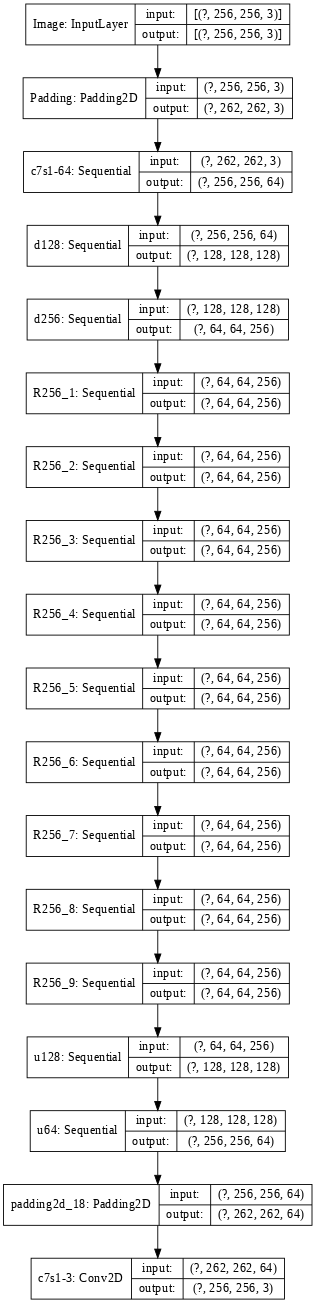

In [19]:
# create the model
model = resnet_generator(
    image_shape=(256, 256, 3), 
		norm_type="InstanceNorm", 
		use_dropout=False,
		n_resnet=9, 
		type_net="nonresnet", 
		padding_type="reflect"
		)

# summarize the model
model.summary()

# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

## U-Net

In [20]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True, use_bias=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.keras.initializers.RandomNormal(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=use_bias))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(tfa.layers.InstanceNormalization(axis=-1))

  result.add(tf.keras.layers.LeakyReLU(0.2))

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False, use_bias=True):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.keras.initializers.RandomNormal(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=use_bias))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(tfa.layers.InstanceNormalization(axis=-1))

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU(0.2))

  return result

In [21]:
def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  assert(output_channels > 0)

  if norm_type.lower()=="batchnorm":

    use_bias = False
  elif norm_type.lower()=="instancenorm":
    use_bias = True
  else:
    raise NotImplementedError('Norm Type [%s] is invalid' % norm_type)

  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False, use_bias=use_bias),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type, use_bias),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type, use_bias),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type, use_bias),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type, use_bias),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type, use_bias),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type, use_bias),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type, use_bias),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True, use_bias=use_bias),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True, use_bias=use_bias),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True, use_bias=use_bias),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type, use_bias),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type, use_bias),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type, use_bias),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type, use_bias),  # (bs, 128, 128, 128)
  ]

  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, 
                                         strides=2,
                                         padding='same', 
                                         kernel_initializer=tf.keras.initializers.RandomNormal(0., 0.02),
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Build the Discriminator

## PatchGAN

1. Each block in the discriminator is (Conv -> Norm -> Leaky ReLU)
2. The shape of the output after the last layer is (batch_size, 30, 30, 1)
3. Each 30x30 patch of the output classifies a 70x70 portion of the input image


In [22]:
def downsampleD(filters, size, strides, name='', norm_type='batchnorm', apply_norm=True, use_bias=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.keras.initializers.RandomNormal(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=use_bias, name=name))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(tfa.layers.InstanceNormalization(axis=-1))

  result.add(tf.keras.layers.LeakyReLU(0.2))

  return result


def PatchDiscriminator(input_shape=(256, 256, 3), n_layers=3, norm_type='batchnorm'):
  """
  PatchGan discriminator model (https://arxiv.org/abs/1611.07004).

  Args:
    norm_type:  --  Type of normalization. Either 'batchnorm' or 'instancenorm'.
    n_layers:   --  Number of layers: 3 for PixelGAN | 5 for ImageGAN

  Returns:
    Discriminator model
  """

  assert(n_layers >= 0)

  if norm_type.lower()=="batchnorm":
    use_bias = False
  elif norm_type.lower()=="instancenorm":
    use_bias = True
  else:
    raise NotImplementedError('Norm Type [%s] is invalid' % norm_type)

  initializer = tf.keras.initializers.RandomNormal(0., 0.02)

  inputs = tf.keras.layers.Input(shape=input_shape, name='Input')

  d = downsampleD(filters=64, size=4, strides=2, norm_type=norm_type, apply_norm=False, use_bias=use_bias, name="C64")(inputs) 

  for n in range(1, n_layers):
    n_filters = 64*min(2**n, 8)
    name = "C"+str(n_filters)+"_"+str(n)
    d = downsampleD(filters=n_filters, size=4, strides=2, name=name, norm_type=norm_type, use_bias=use_bias)(d) 

  d = downsampleD(filters=64*min(2**n_layers, 8), size=4, strides=1, norm_type=norm_type, use_bias=use_bias, name="C512")(d) 

  outputs = tf.keras.layers.Conv2D(filters=1, 
                                   kernel_size=4, 
                                   strides=1,
                                   padding="same",
                                   kernel_initializer=initializer,
                                   name="Output")(d)  

  return tf.keras.Model(inputs=inputs, outputs=outputs, name="PatchGAN")

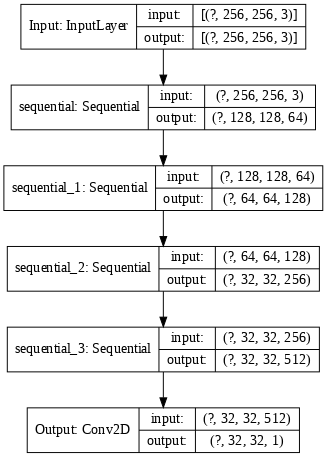

In [23]:
discriminator = PatchDiscriminator(n_layers=3, norm_type="instancenorm")

tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=70)

## PixelGAN

In [24]:
def decode(filters, size, norm_type='batchnorm', apply_norm=True, use_bias=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.keras.initializers.RandomNormal(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='valid',
                             kernel_initializer=initializer, use_bias=use_bias))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(tfa.layers.InstanceNormalization(axis=-1))

  result.add(tf.keras.layers.LeakyReLU(0.2))

  return result


def PixelDiscriminator(input_shape=(256, 256, 3), norm_type='batchnorm'):
  """
  Construct a 1x1 PatchGAN Descriminator (pixelGAN)

  Args:
    norm_type:  --  Type of normalization. Either 'batchnorm' or 'instancenorm'.

  Returns:
    Discriminator model
  """

  if norm_type.lower()=="batchnorm":
    use_bias = False
  elif norm_type.lower()=="instancenorm":
    use_bias = True
  else:
    raise NotImplementedError('Norm Type [%s] is invalid' % norm_type)

  initializer = tf.keras.initializers.RandomNormal(0., 0.02)

  inputs = tf.keras.layers.Input(shape=input_shape, name='input_image')

  d = decode(64, 1, norm_type, apply_norm=False, use_bias=use_bias)(inputs) 
  d = decode(128, 1, norm_type, use_bias=use_bias)(d)

  outputs = tf.keras.layers.Conv2D(filters=1, 
                                   kernel_size=1, 
                                   strides=1, 
                                   padding="valid",
                                   kernel_initializer=initializer,
                                   use_bias=use_bias)(d) 

  return tf.keras.Model(inputs=inputs, outputs=outputs)

# CycleGAN Architecture

In [25]:
generator_G = resnet_generator()  # unet_generator(3, norm_type='instancenorm')
generator_F = resnet_generator()  # unet_generator(3, norm_type='instancenorm')

discriminator_X = PatchDiscriminator(norm_type="instancenorm") # PixelDiscriminator | PatchDiscriminator(n_layer=5)
discriminator_Y = PatchDiscriminator(norm_type="instancenorm") # PixelDiscriminator | PatchDiscriminator(n_layer=5)

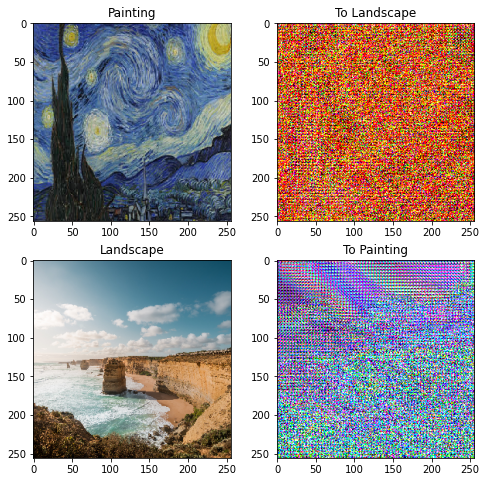

In [26]:
G_Y = generator_G(imgX)
F_X = generator_F(imgY)

plt.figure(figsize=(8,8))
contrast = 8

imgs = [imgX, G_Y, imgY, F_X]
title = ["Painting", "To Landscape", "Landscape", "To Painting"]

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

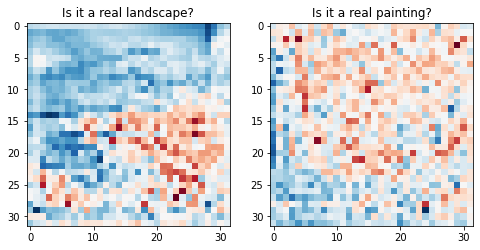

In [27]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title("Is it a real landscape?")
plt.imshow(discriminator_Y(imgY)[0,...,-1], cmap="RdBu_r")

plt.subplot(122)
plt.title("Is it a real painting?")
plt.imshow(discriminator_X(imgX)[0,...,-1], cmap="RdBu_r")

plt.show()

# Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input X and the target pair Y are meaningful during training. Thus in order to enforcee that network learns the correct mapping, the cycle consistency loss is used.

In [28]:
mse_loss = tf.keras.losses.MeanSquaredError()
mae_loss = tf.keras.losses.MeanAbsoluteError()

## Adversarial Loss

In [29]:
def discriminator_loss(real, generated):
  real_loss = mse_loss(tf.ones_like(real), real)
  generated_loss = mse_loss(tf.zeros_like(generated), generated)
  total_discrimator_loss = real_loss + generated_loss

  return total_discrimator_loss * 0.5


def generator_loss(generated):
  return mse_loss(generated, tf.ones_like(generated))

## Cycle Consistency Loss

1. Image X is passed via generator G that yields generated image $\hat{Y}$.
2. Generated image $\hat Y$ is passed via generator F that yields cycled image $\hat X$.
3. Mean absolute error is calculated between X and $\hat X$.

$\text{forward cycle consistency loss: } X->G(X)->F(G(X))\sim \hat X $

$\text{backward cycle consistency loss: } Y->F(Y)->G(F(Y))\sim \hat Y $

![alt text](https://www.tensorflow.org/tutorials/generative/images/cycle_loss.png)

In [30]:
def calc_cycle_loss(real_image, cycled_image):
  return LAMBDA * mae_loss(real_image, cycled_image)

## Identity Loss

The generator G is responsible for translating image X to image Y. Identity loss says that, if you feed image Y to generator G, it should yield real image Y or something close to Y.

$\text{Identity loss}=|G(Y)-Y|+|F(X)-X|$

In [31]:
def identity_loss(real_image, same_image):
  loss = mae_loss(real_image, same_image)

  return LAMBDA * loss * 0.5

## Learning Rate Scheduler

The learning rate is same for the first 100 epochs and linearly decay the rate to zero over the next 100 epochs

In [32]:
class LinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    # if `step` < `step_decay`: use fixed learning rate
    # else: linearly decay the learning rate to zero
    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self._initial_learning_rate,
            'total_steps': self._steps,
            'step_decay': self._step_decay,
        }

## Optimizer

In [33]:
gen_lr_scheduler = LinearDecay(LEARNING_RATE, EPOCHS * total_batches, DECAY_EPOCHS * total_batches)
dis_lr_scheduler = LinearDecay(LEARNING_RATE, EPOCHS * total_batches, DECAY_EPOCHS * total_batches)

# Initialize the optimizers for all the generators and the discriminators
generator_G_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_lr_scheduler, beta_1=BETA_1)
generator_F_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_lr_scheduler, beta_1=BETA_1)

discriminator_X_optimizer = tf.keras.optimizers.Adam(learning_rate=dis_lr_scheduler, beta_1=BETA_1)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(learning_rate=dis_lr_scheduler, beta_1=BETA_1)

# Checkpoints

In [34]:
# Prepare a directory to store all the checkpoints
checkpoint_dir = "./checkpoints/train"

checkpoint = tf.train.Checkpoint(generator_G=generator_G,
                                generator_F=generator_F,
                                discriminator_X=discriminator_X,
                                discriminator_Y=discriminator_Y,
                                generator_G_optimizer=generator_G_optimizer,
                                generator_F_optimizer=generator_F_optimizer,
                                discriminator_X_optimizer=discriminator_X_optimizer,
                                discriminator_Y_optimizer=discriminator_Y_optimizer,
                                epoch=tf.Variable(0))

checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=2)

# if a checkpoint exists, restore the latest checkpoint.
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoint)
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
else:
  print("Initializing from scratch.")

Restored from ./checkpoints/train/ckpt-27


# Training

In [35]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
                    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [36]:
def generate_images(model, test_input, name):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  plt.savefig(fname=name, bbox_inches='tight')
  plt.show()

Training loop consists of four basic steps:

1. Get the predictions
2. Calculate the loss
3. Calculate the gradient using backpropagation
4. Apply the gradient to the optimizer

In [37]:
@tf.function
def train_step(epoch, real_X, real_Y):
  
  # persistent is set to True because the tape is used more than once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_Y = generator_G(real_X, training=True)
    cycled_X = generator_F(fake_Y, training=True)

    fake_X = generator_F(real_Y, training=True)
    cycled_Y = generator_G(fake_X, training=True)

    # same_X and same_Y are used for identity loss.
    same_X = generator_F(real_X, training=True)
    same_Y = generator_G(real_Y, training=True)

    disc_real_X = discriminator_X(real_X, training=True)
    disc_real_Y = discriminator_Y(real_Y, training=True)

    disc_fake_X = discriminator_X(fake_X, training=True)
    disc_fake_Y = discriminator_Y(fake_Y, training=True)

    # calculate the adversarial loss
    gen_G_loss = generator_loss(disc_fake_Y)
    gen_F_loss = generator_loss(disc_fake_X)
    
    # calculate the cycle consistent loss
    total_cycle_loss = calc_cycle_loss(real_X, cycled_X) + calc_cycle_loss(real_Y, cycled_Y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_Y, same_Y)
    total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_X, same_X)

    disc_X_loss = discriminator_loss(disc_real_X, disc_fake_X)
    disc_Y_loss = discriminator_loss(disc_real_Y, disc_fake_Y)
  
  # Calculate the gradients for generator and discriminator
  generator_G_gradients = tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
  generator_F_gradients = tape.gradient(total_gen_F_loss, generator_F.trainable_variables)
  
  discriminator_X_gradients = tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
  discriminator_Y_gradients = tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_G_optimizer.apply_gradients(zip(generator_G_gradients, generator_G.trainable_variables))
  generator_F_optimizer.apply_gradients(zip(generator_F_gradients, generator_F.trainable_variables))
  
  discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients, discriminator_X.trainable_variables))
  discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, discriminator_Y.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=epoch)
    tf.summary.scalar('total_gen_G_loss', total_gen_G_loss, step=epoch)
    tf.summary.scalar('total_gen_F_loss', total_gen_F_loss, step=epoch)
    tf.summary.scalar('gen_G_loss', gen_G_loss, step=epoch)
    tf.summary.scalar('gen_F_loss', gen_F_loss, step=epoch)
    tf.summary.scalar('disc_X_loss', disc_X_loss, step=epoch)
    tf.summary.scalar('disc_Y_loss', disc_Y_loss, step=epoch)

In [38]:
def fit(epochs, dataset):
  for epoch in range(int(checkpoint.epoch), epochs):
    start = time.time()
    print('Epoch {} starts. Learning rate: {}, {}'.format(epoch, gen_lr_scheduler.current_learning_rate.value().numpy(),
                                                                dis_lr_scheduler.current_learning_rate.value().numpy()))

    for n, (image_x, image_y) in dataset.enumerate():
      train_step(epoch, image_x, image_y)
      if n % 10 == 0:
        print ('.', end='')
      
    clear_output(wait=True)

    # Using a consistent image (paintings) so that the progress of the model is clearly visible.
    generate_images(generator_G, imgX, name="train_images/G_gen/to_landscape" + str(epoch+1) + ".png")
    generate_images(generator_F, imgY, name="train_images/F_gen/to_painting" + str(epoch+1) + ".png")

    # Save checkpoint
    checkpoint.epoch.assign_add(1)

    checkpoint_save_path = checkpoint_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, checkpoint_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [39]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 1590), started 3:34:10 ago. (Use '!kill 1590' to kill it.)

<IPython.core.display.Javascript object>

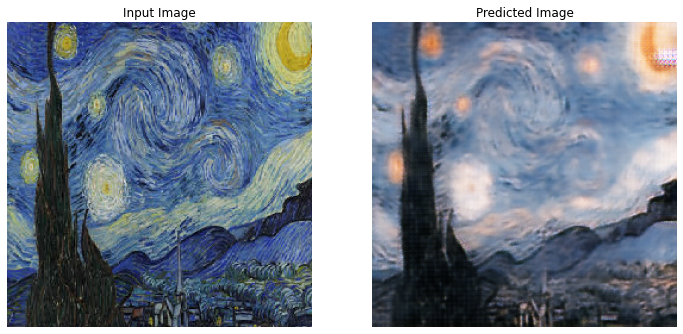

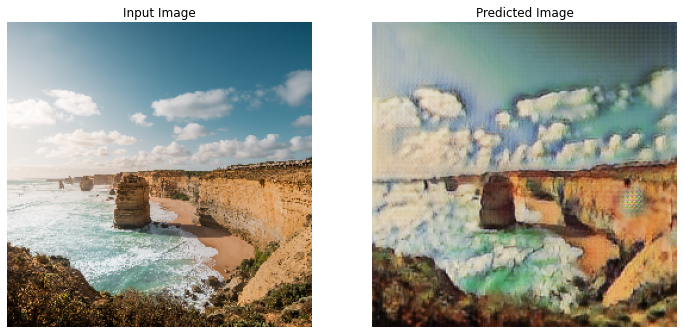

Saving checkpoint for epoch 29 at ./checkpoints/train/ckpt-29
Time taken for epoch 29 is 473.3190107345581 sec

Epoch 29 starts. Learning rate: 0.00019999999494757503, 0.00019999999494757503
.............................................

In [ ]:
fit(EPOCHS, train_dataset)
print('Finished training.')